# Different Alpha in the activation functions 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from utils_activation_FO import *
from utils import model, preprocessing, plots

# ================= LOAD DATA =================
data = pd.read_csv("data/signals_FO.csv")

in1 = data['in1'].to_numpy()
in2 = data['in2'].to_numpy()
out = data['out'].to_numpy()


2026-02-06 15:28:53.143662: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-06 15:28:53.143883: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-06 15:28:53.173571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 15:28:53.989084: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
N_REGRESSORS = 5
N_STEPS_AHEAD = 5
# ================= NARX FORM =================
# X(t) = [in1(t), in2(t), out(t-1)]
# y(t) = out(t)

# X = np.column_stack([
#     in1[1:],      # in1(t)
#     in2[1:],      # in2(t)
#     out[:-1]      # out(t-1)
# ])

# y = out[1:]      # out(t)

X, y = preprocessing.create_data(data, N_REGRESSORS, N_STEPS_AHEAD, last_only=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)




In [3]:
# Input scaling
x_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = x_scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))

X_test = x_scaler.transform(X_test.reshape(X_test.shape[0], -1))


# Output scaling (regresija!)
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))


[10, 10]

In [ ]:
# ============== SETUP =============
num_input = X_train.shape[1]   
num_hidden = 10
num_output = y_train.shape[1]   
seed2 = 10
num_hidden_layers = 2

### num_hidden can be an int (same for all layers) or a list (different for each layer) -> [num_hidden] * num_hidden_layers
### num_hidden_layers is the number of hidden layers (not counting the output layer)

# M1 : Classical Activation Functions 
model_fixed = model.fixed(num_input, num_hidden, num_output, num_hidden_layers=num_hidden_layers, activation='relu')
model_fixed.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)


# M2 : Shared alpha per-layer
model_per_layer = model.per_layer(num_input, num_hidden, num_output, num_hidden_layers=num_hidden_layers, act="Relu", seed=seed2)
model_per_layer.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)


# M3 : Per-neuron alpha
model_per_neuron = model.per_neuron(num_input, num_hidden, num_output, num_hidden_layers=num_hidden_layers, activation='Relu', seed=seed2)
model_per_neuron.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)


2026-02-06 15:28:55.038660: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
alpha_before = {
    'per_layer': model.get_initial_alpha(model_per_layer),
    'per_neuron': model.get_initial_alpha(model_per_neuron)
}

In [6]:
models = {
    "fixed": model_fixed,
    "per_layer": model_per_layer,
    "per_neuron": model_per_neuron
}


In [7]:
EPOCHS = 100
BATCH_SIZE = 32
histories = model.train_models(X_train, y_train, models, EPOCHS=EPOCHS, BATCH_SIZE=BATCH_SIZE, show_progress=True, EarlyStopping=True)

# EarlyStopping is a flag used to include the EarlyStopping callback during training, which helps prevent overfitting by stopping the training process 
# when the validation loss stops improving and also to reduce the training time by avoiding unnecessary epochs once the model has converged.

Training models: 100%|██████████| 3/3 [00:36<00:00, 12.11s/it]


In [8]:
alpha_after = {
    'per_layer': model.get_trained_alpha(model_per_layer),
    'per_neuron': model.get_trained_alpha(model_per_neuron)
}

In [9]:
model.print_alpha(alpha_before, alpha_after, models, type='per_neuron')

Per-neuron alpha:
Layer 'per_neuron_relu':
Before: [-0.7606, 0.0189, 0.9251, -0.5418, 0.7680, 0.7877, 0.3339, 0.9151, -0.0234, 0.6966,]
After:  [-0.2377, -0.1184, 0.2975, -0.0650, 0.0439, 0.4007, 0.0107, 0.4199, 0.0423, 0.4314,]
Layer 'per_neuron_relu_1':
Before: [-0.0919, 0.0350, 0.1912, 0.5242, -0.5894, -0.7176, 0.4967, 0.9943, -0.1425, -0.5316,]
After:  [0.0388, 0.0371, 0.1954, 0.2385, -0.2870, -0.4216, 0.3169, 0.4150, -0.0055, -0.2759,]


In [10]:
model.print_alpha(alpha_before, alpha_after, models, type='per_layer')

Per-layer alpha:
Layer 'per_layer_relu':
Before: [0.6112]
After:  [0.3558]
Layer 'per_layer_relu':
Before: [0.6112]
After:  [0.3558]


In [11]:
model.print_alpha(alpha_before, alpha_after, models, type='comparison')

Per-layer alpha:
Layer 'per_layer_relu':
Before: [0.6112]
After:  [0.3558]
Layer 'per_layer_relu':
Before: [0.6112]
After:  [0.3558]


Per-neuron alpha:
Layer 'per_neuron_relu':
Before: [-0.7606, 0.0189, 0.9251, -0.5418, 0.7680, 0.7877, 0.3339, 0.9151, -0.0234, 0.6966,]
After:  [-0.2377, -0.1184, 0.2975, -0.0650, 0.0439, 0.4007, 0.0107, 0.4199, 0.0423, 0.4314,]
Layer 'per_neuron_relu_1':
Before: [-0.0919, 0.0350, 0.1912, 0.5242, -0.5894, -0.7176, 0.4967, 0.9943, -0.1425, -0.5316,]
After:  [0.0388, 0.0371, 0.1954, 0.2385, -0.2870, -0.4216, 0.3169, 0.4150, -0.0055, -0.2759,]


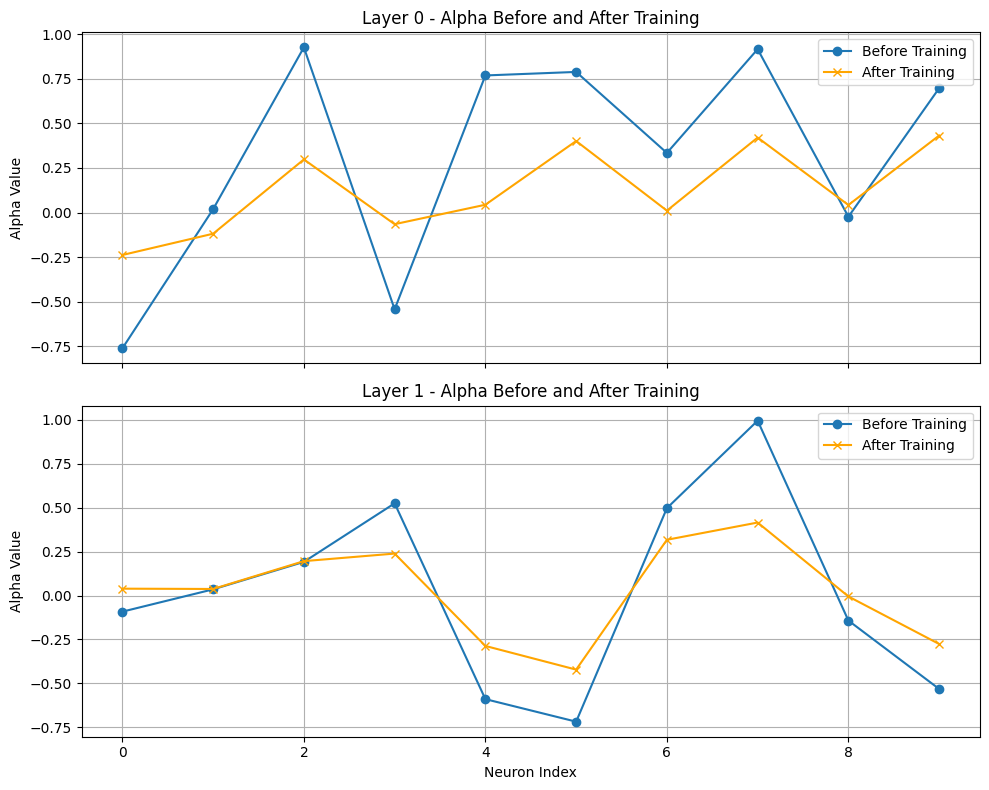

In [12]:
model.plot_alpha_comparison(alpha_before, alpha_after)

In [13]:
p = plots(histories, models, X_test, y_test, y_scaler)
metrics = p.print_final_metrics()

FINAL EVALUATION METRICS

Model Fixed:
  Test MSE: 0.000272
  Test MAE: 0.011031

Model Per-Layer:
  Test MSE: 0.000110
  Test MAE: 0.007681

Model Per-Neuron:
  Test MSE: 0.000155
  Test MAE: 0.008260


In [14]:
metrics # Saving the metrics into a dataframe for easier comparison and exporting to csv for further analysis.

,Model,MSE,MAE
0,Fixed,0.000272,0.011031
1,Per-Layer,0.000110,0.007681
2,Per-Neuron,0.000155,0.008260


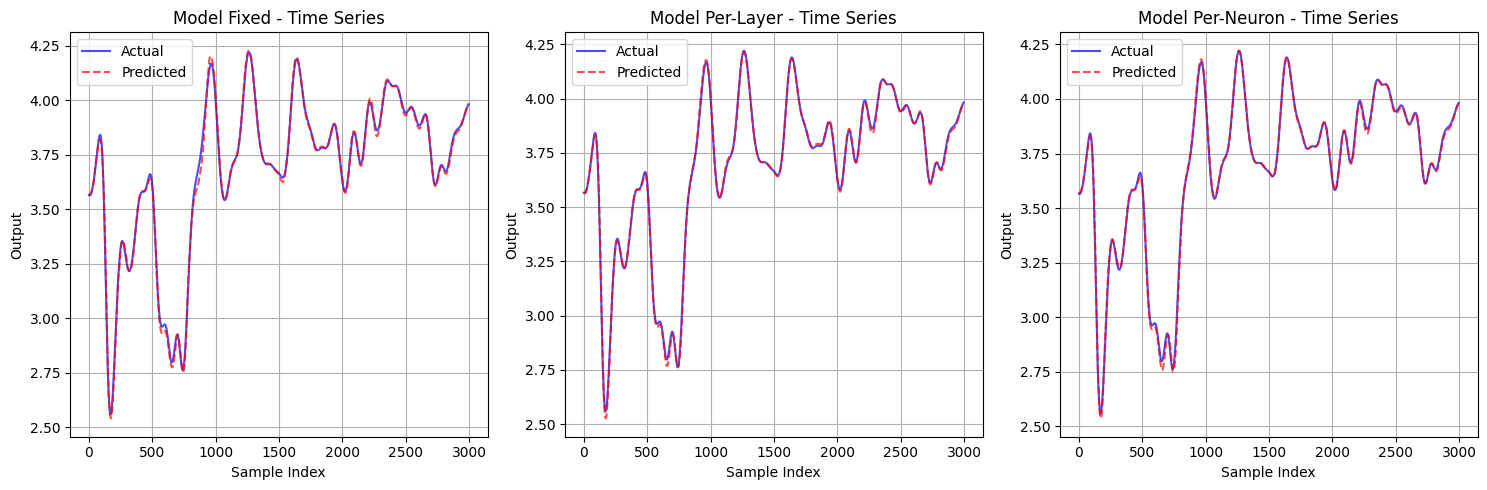

In [15]:
p.plot_time_series(sample_size=-1)  #You can set sample_size to a specific number to plot only a subset of the time series, or -1 to plot the entire series.

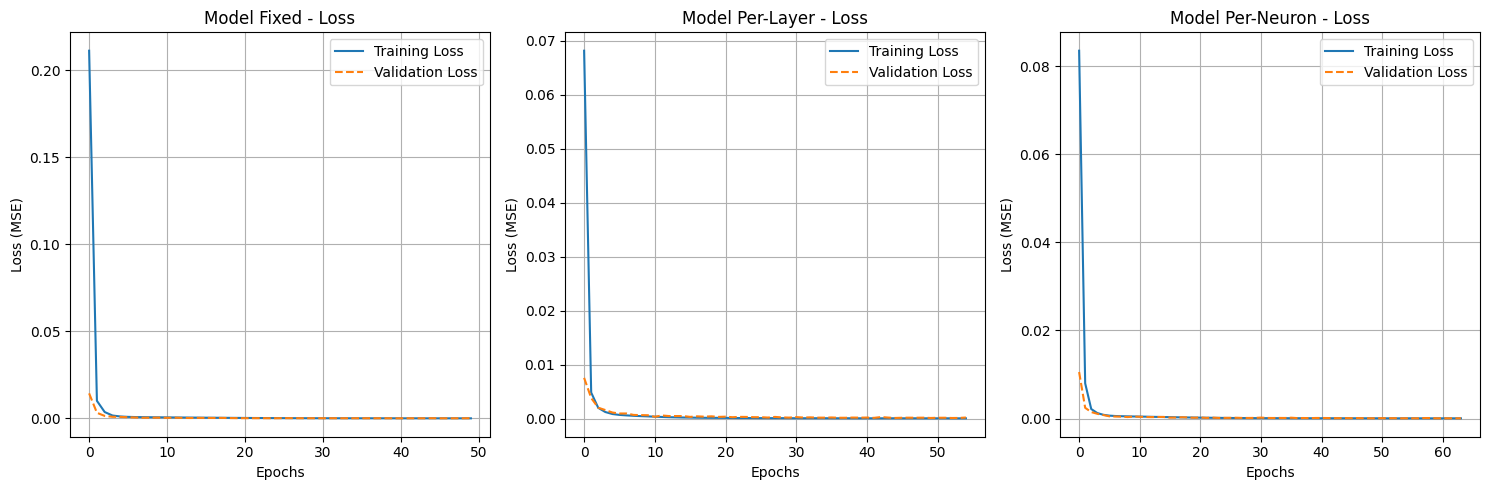

In [16]:
p.plot_history()

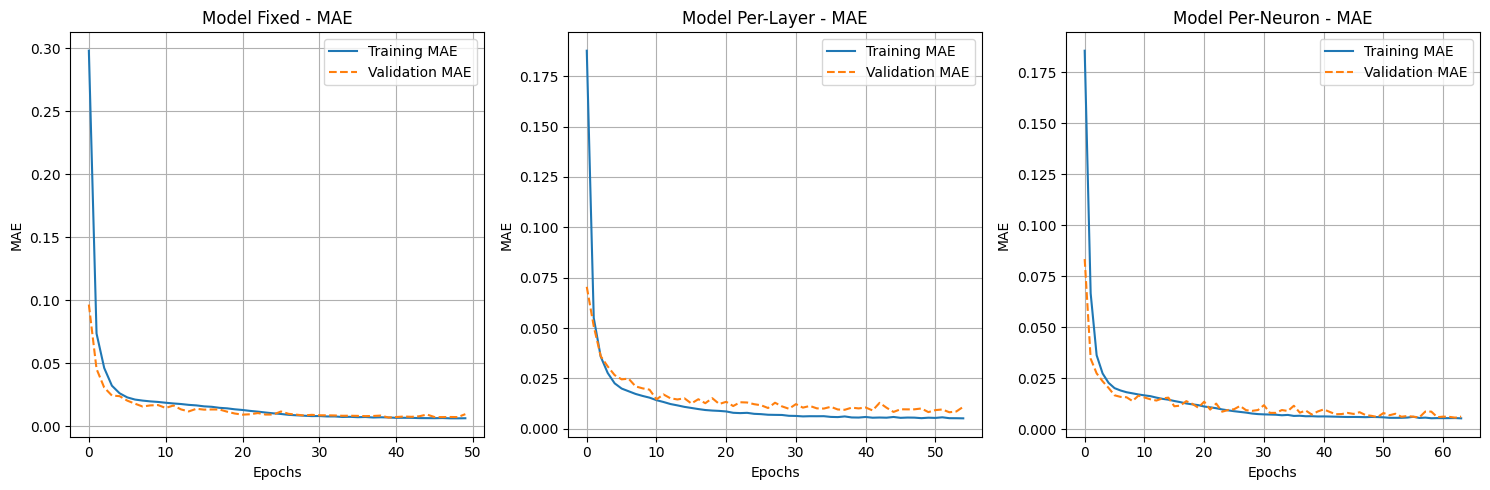

In [17]:
p.plot_mae()

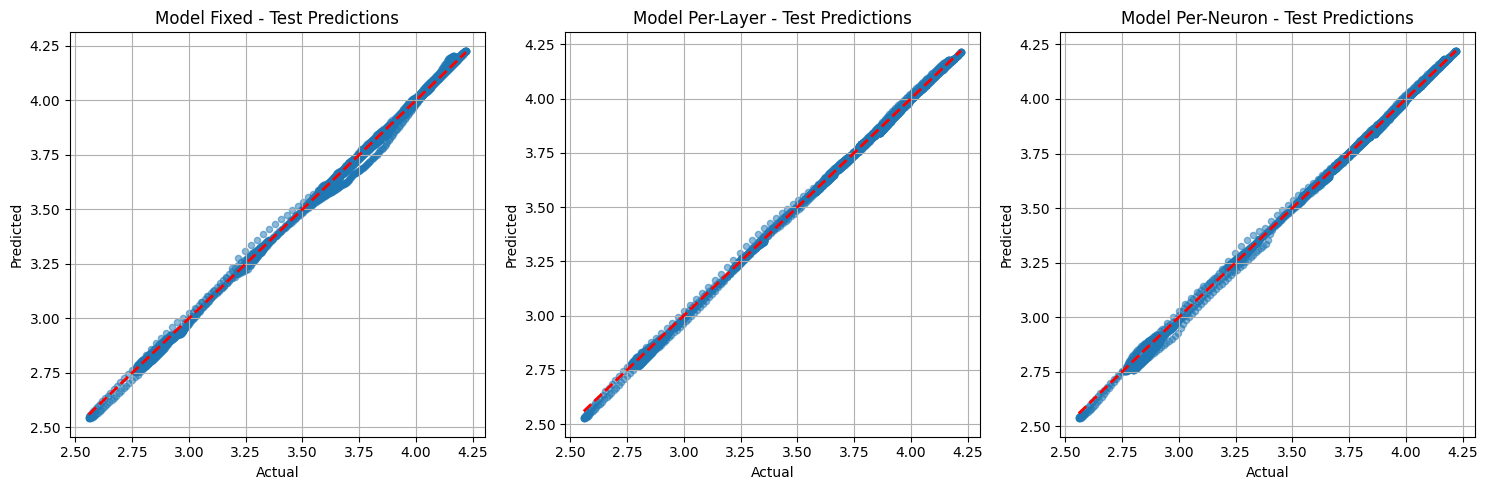

In [18]:
p.plot_predictions()